終端コスト固定


反復学習: イテレーション 1/4

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms ( 68.97us)   4.07ms (140.28us)        29
       nlp_g  |   1.00ms ( 34.48us)   2.83ms ( 97.62us)        29
  nlp_grad_f  |   5.00ms (166.67us)   7.19ms (239.63us)        30
  nlp_hess_l  |  12.00ms (428.57us)  14.93ms (533.29us)        28
   nlp_jac_g  |  20.00ms (666.67us)   7.67ms (255.83us)        30
       total  | 208.00ms (208.00ms) 207.94ms (207.94ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 35.71us)   3.74ms (133.71us)        28


 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\rbf.py:178: RuntimeWarning:invalid value encountered in multiply
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in divide


GPR: 学習完了

反復学習: イテレーション 2/4
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.00ms (185.19us)   7.57ms (280.41us)        27
       nlp_g  |   5.00ms (185.19us)   5.35ms (198.33us)        27
  nlp_grad_f  |  12.00ms (428.57us)  11.62ms (414.86us)        28
  nlp_hess_l  |  24.00ms (923.08us)  25.72ms (989.27us)        26
   nlp_jac_g  |   7.00ms (250.00us)  12.36ms (441.43us)        28
       total  | 295.00ms (295.00ms) 288.70ms (288.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.00ms (200.00us)   3.35ms (167.40us)        20
       nlp_g  |        0 (       0)   2.22ms (110.80us)        20
  nlp_grad_f  |   6.00ms (285.71us)   5.66ms (269.43us)        21
  nlp_hess_l  |  10.00ms (526.32us)  10.71ms (563.58us)        19
   nlp_jac_g  |   8.00ms (380.95us)   5.85ms (278.71us)        21
       total  | 131.00ms (131.00ms) 130.20ms (130.20ms)         1
      solver  :   t_proc      (avg)   t_wall   

 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in divide


GPR: 学習完了

反復学習: イテレーション 3/4
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.00ms (172.41us)   3.56ms (122.72us)        29
       nlp_g  |        0 (       0)   2.33ms ( 80.31us)        29
  nlp_grad_f  |  12.00ms (400.00us)   6.70ms (223.37us)        30
  nlp_hess_l  |  16.00ms (571.43us)  12.30ms (439.25us)        28
   nlp_jac_g  |  16.00ms (533.33us)   6.99ms (233.13us)        30
       total  | 217.00ms (217.00ms) 222.64ms (222.64ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.00ms (523.81us)   2.54ms (120.95us)        21
       nlp_g  |        0 (       0)   1.61ms ( 76.52us)        21
  nlp_grad_f  |  11.00ms (500.00us)   4.66ms (211.82us)        22
  nlp_hess_l  |        0 (       0)   8.93ms (446.55us)        20
   nlp_jac_g  |  17.00ms (772.73us)   4.97ms (226.00us)        22
       total  | 132.00ms (132.00ms) 128.77ms (128.77ms)         1
      solver  :   t_proc      (avg)   t_wall   

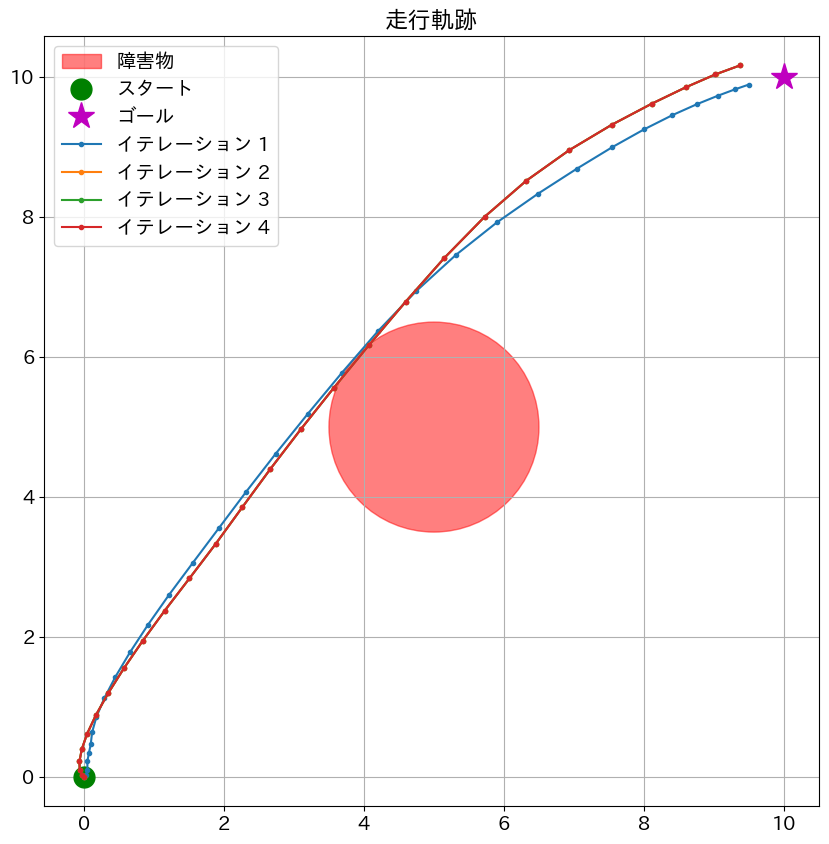

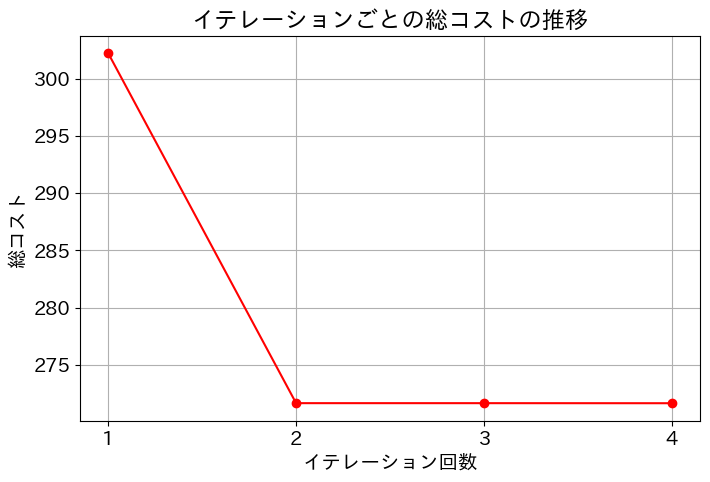

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import casadi as ca
import time

# Matplotlibの日本語設定とスタイル設定
import japanize_matplotlib
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (8, 8)

# ==================================================================================
# シミュレーション全体の設定パラメータ
# ==================================================================================
N_ITERATIONS = 4
SIM_STEPS = 100
DT = 0.1
NX, NU = 4, 2
START_STATE = np.array([0.0, 0.0, 0.0, 0.0])
GOAL_STATE = np.array([10.0, 10.0])
N_MPC = 20
M_MPC = 20 
OBSTACLE_INFO = {'pos': np.array([5.0, 5.0]), 'rad': 1.5}

# ==================================================================================
# ✅ 変更点１：SafeSet クラスの新規作成
# ==================================================================================
class SafeSet:
    """過去の軌跡データから安全集合とコスト・トゥ・ゴーを管理するクラス"""
    def __init__(self):
        # (状態, コスト・トゥ・ゴー) のタプルを格納するリスト
        self.database = []
        self.is_initialized = False

    def add_trajectory(self, trajectory_data):
        """1回のイテレーションデータをデータベースに追加する"""
        costs_to_go = []
        running_cost = 0
        # 軌跡の最後から逆算して、各状態からのコスト・トゥ・ゴーを計算
        for state, stage_cost in reversed(trajectory_data):
            running_cost += stage_cost
            self.database.append((state, running_cost))
        
        if self.database:
            self.is_initialized = True

    def get_best_point_and_cost(self):
        """データベースから最も優秀な点（コスト最小）とそのコストを返す"""
        if not self.is_initialized:
            # データがない場合は、ゴール地点を目標とし、コストはゼロと仮定
            return GOAL_STATE, 0.0
        
        # データベース内でコストが最小のタプルを見つける
        best_point, min_cost = min(self.database, key=lambda item: item[1])
        return best_point[:2], min_cost # 位置情報とコストのみ返す


# ----------------------------------------------------------------------------------
# Component 1: シミュレーション環境 (真のシステム)
# ----------------------------------------------------------------------------------
class TrueVehicle:
    def __init__(self, dt=0.1):
        self.dt = dt
    def dynamics(self, x, u):
        px, py, vx, vy = x; ax, ay = u
        # GPRが学習すべき、モデル化されていない非線形項
        drag = 0.1
        vx_next = vx + (ax - drag * vx**2) * self.dt
        vy_next = vy + (ay - drag * vy**2) * self.dt
        px_next = px + vx * self.dt + 0.5 * ax * self.dt**2
        py_next = py + vy * self.dt + 0.5 * ay * self.dt**2
        return np.array([px_next, py_next, vx_next, vy_next])

# ----------------------------------------------------------------------------------
# Component 2: ガウス過程回帰モデル (ダイナミクス学習)
# ----------------------------------------------------------------------------------
class GPRModel:
    def __init__(self, nx, nu, dt, obstacle_info):
        self.nx, self.nu = nx, nu
        self.dt=DT
        self.obstacle_info=OBSTACLE_INFO
        self.is_trained = False
        self.X_data = np.empty((0, self.nx + self.nu))
        self.Y_data = np.empty((0, self.nx))
        self.models = [None] * self.nx

    def add_data(self, x, u, x_next):
        # 公称モデルからの誤差（デルタ）を学習ターゲットにする
        delta_real = (x_next - x) / self.dt
        delta_nominal = np.array([x[2], x[3], u[0], u[1]])
        error = delta_real - delta_nominal
        self.X_data = np.vstack([self.X_data, np.hstack([x, u])])
        self.Y_data = np.vstack([self.Y_data, error])

    def train(self):
        if len(self.X_data) < 10: return
        print("GPR: 学習開始...")
        for i in range(self.nx):
            kernel = GPy.kern.RBF(input_dim=self.nx + self.nu, ARD=True)
            model = GPy.models.GPRegression(self.X_data, self.Y_data[:, i:i+1], kernel)
            model.optimize(messages=False, max_iters=100)
            self.models[i] = model
        self.is_trained = True
        print("GPR: 学習完了")

    def predict(self, x, u):
        if not self.is_trained:
            return np.zeros(self.nx), np.ones(self.nx)
        xu = np.hstack([x, u]).reshape(1, -1)
        means = np.array([m.predict(xu)[0][0, 0] if m else 0 for m in self.models])
        variances = np.array([m.predict(xu)[1][0, 0] if m else 1.0 for m in self.models])
        return means, variances

# ----------------------------------------------------------------------------------
# Component 3: MPCコントローラ
# ----------------------------------------------------------------------------------
class MPCController:
    def __init__(self, nx, nu, N, M, dt, obstacle_info):
        self.nx, self.nu, self.N, self.M, self.dt = nx, nu, N, M, dt
        self.obstacle_info = obstacle_info
        self.u_prev_sol = np.zeros((nu, N))

    # ✅ 変更点：solveメソッドをサンプルベースMPCのロジックに書き換え
    def solve(self, x_current, gpr_model, x_goal):
        opti = ca.Opti()
        U = opti.variable(self.nu, self.N)

        # 1. GPRから誤差の平均と分散を取得
        error_mean, error_var = gpr_model.predict(x_current, np.zeros(self.nu))
        error_std = np.sqrt(np.maximum(error_var, 1e-6))
        # 安定化のため、不確実性の上限を設定
        error_std_capped = np.minimum(error_std, 0.2)
        
        # 2. M個の誤差サンプルを生成
        np.random.seed(int(time.time()))
        error_samples = np.random.normal(loc=error_mean, scale=error_std_capped, size=(self.M, self.nx))
        
        all_scenario_costs = []
        
        # 3. M個のシナリオについてループ
        for m in range(self.M):
            X_scenario = opti.variable(self.nx, self.N + 1)
            cost_scenario = 0
            opti.subject_to(X_scenario[:, 0] == x_current)
            
            # 予測ホライズンNステップの計算
            for k in range(self.N):
                x_k, u_k = X_scenario[:, k], U[:, k]
                
                # 4. i番目のサンプルを使って未来を予測
                delta_nominal = ca.vertcat(x_k[2], x_k[3], u_k[0], u_k[1])
                # GPRが予測した平均誤差と、i番目のランダム誤差を足し合わせる
                delta_pred = delta_nominal + error_samples[m, :]
                x_next_pred = x_k + delta_pred * self.dt
                opti.subject_to(X_scenario[:, k+1] == x_next_pred)

                # コスト計算
                cost_scenario += ca.sumsqr(x_k[:2] - x_goal) * self.dt
                cost_scenario += ca.sumsqr(u_k) * self.dt * 0.01
                if self.obstacle_info:
                    dist_to_obs = ca.norm_2(x_k[:2] - self.obstacle_info['pos'])
                    penalty = ca.fmax(0, self.obstacle_info['rad'] - dist_to_obs)
                    cost_scenario += 500.0 * penalty**2
            
            cost_scenario += ca.sumsqr(X_scenario[:2, self.N] - x_goal) * 20.0
            all_scenario_costs.append(cost_scenario)
        
        # 5. 全シナリオの平均コストを目的関数とする
        #total_objective = ca.mean(ca.vertcat(*all_scenario_costs))
        total_objective = ca.sum1(ca.vertcat(*all_scenario_costs)) / len(all_scenario_costs)
        opti.minimize(total_objective)

        # (制約とソルバー設定は変更なし)
        opti.subject_to(opti.bounded(-5.0, U, 5.0))
        opti.set_initial(U, self.u_prev_sol)
        s_opts = {'print_level': 0}; opti.solver('ipopt', {}, s_opts)

        try:
            sol = opti.solve()
            self.u_prev_sol = np.hstack((sol.value(U)[:, 1:], sol.value(U)[:, -1].reshape(-1, 1)))
            return sol.value(U[:, 0])
        except Exception as e:
            print(f"MPC: 最適化失敗。x={x_current}, error: {e}")
            return np.zeros(self.nu)

# ----------------------------------------------------------------------------------
# Main Simulation Loop
# ----------------------------------------------------------------------------------
def main():
    vehicle = TrueVehicle(dt=DT)
    gpr_model = GPRModel(nx=NX, nu=NU, dt=DT, obstacle_info=OBSTACLE_INFO)
    mpc = MPCController(nx=NX, nu=NU, N=N_MPC, M=M_MPC, dt=DT, obstacle_info=OBSTACLE_INFO)

    all_trajectories, final_costs = [], []

    for i in range(N_ITERATIONS):
        print(f"\n{'='*50}\n反復学習: イテレーション {i+1}/{N_ITERATIONS}\n{'='*50}")
        current_x = np.copy(START_STATE)
        total_cost = 0
        iteration_data = []

        for step in range(SIM_STEPS):
            u_optimal = mpc.solve(current_x, gpr_model, GOAL_STATE)
            x_next = vehicle.dynamics(current_x, u_optimal)
            
            stage_cost = (np.sum((current_x[:2] - GOAL_STATE)**2) + np.sum(u_optimal**2) * 0.01) * DT
            total_cost += stage_cost
            iteration_data.append((current_x, u_optimal, x_next))
            current_x = x_next

            if np.linalg.norm(current_x[:2] - GOAL_STATE) < 0.5:
                print(f"ステップ {step+1} でゴールに到達！")
                break
        
        all_trajectories.append(np.array([d[0] for d in iteration_data]))
        final_costs.append(total_cost)
        print(f"イテレーション {i+1} の総コスト: {total_cost:.2f}")

        for x, u, x_n in iteration_data:
            gpr_model.add_data(x, u, x_n)
        gpr_model.train()

    # --- 結果の可視化 ---
    plt.figure(figsize=(10, 10))
    if OBSTACLE_INFO is not None:
        obs_circle = plt.Circle(OBSTACLE_INFO['pos'], OBSTACLE_INFO['rad'], color='r', alpha=0.5, label='障害物')
        plt.gca().add_patch(obs_circle)
    plt.plot(START_STATE[0], START_STATE[1], 'go', markersize=15, label='スタート')
    plt.plot(GOAL_STATE[0], GOAL_STATE[1], 'm*', markersize=20, label='ゴール')
    for i, traj in enumerate(all_trajectories):
        plt.plot(traj[:, 0], traj[:, 1], '-o', markersize=3, label=f'イテレーション {i+1}')
    plt.title('走行軌跡')
    plt.legend()
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, N_ITERATIONS + 1), final_costs, '-ro')
    plt.title('イテレーションごとの総コストの推移')
    plt.xlabel('イテレーション回数')
    plt.ylabel('総コスト')
    plt.xticks(range(1, N_ITERATIONS + 1))
    plt.show()

if __name__ == '__main__':
    main()